In [1]:
%matplotlib inline
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as mse
import matplotlib.lines as lines
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [2]:
X = pd.read_csv("./data/processed/gw_stage.CSV",
                    parse_dates=['Datetime'],
                    index_col=['Datetime'])
print('Initial Input Size: ',X.shape)
y = pd.read_csv("./data/processed/spring.CSV",
                    parse_dates=['datetime'],
                    index_col=['datetime'])
key_value = np.loadtxt("./data/processed/NameKey.CSV", dtype= "str", delimiter=",", skiprows=1)
stationNames = { k:v for k,v in key_value }

tooClose=['8','9','10','12','14','25', '44', '61', '74']
for i in tooClose:
    print(stationNames[i])

#Drop values exctremely close to the Spring head
X.drop(X.columns[[8,9,10,12, 14, 25,44,61,74]], axis=1, inplace=True)
print("Excluded Input Shape: ", X.shape)
X.rename(columns = stationNames, inplace = True)
train_names=X.columns

Initial Input Size:  (1101, 76)
NWFWMD-NITRATE 
NWFWMD-NITRATE 
NWFWMD-NITRATE 
NWFWMD-NITRATE 
WAKULLA CONDUIT WELL@WEST OF HWY 61
NWFWMD GW-12F (RIVERSPRINGS MS)/S820
St. Marks River @ San Marcos de Apalachee S.P.
WAKULLA RIVER AT BOAT TRAM
INDIAN SPRING RUN AT SR61
Excluded Input Shape:  (1101, 67)


In [3]:
#Scale Value
mm=MinMaxScaler()
ss=StandardScaler()
X_ss=ss.fit_transform(X)
y_mm=mm.fit_transform(y)

#Splitting to a 70 Train:30 Test
X_train=X_ss[:770,:]
X_test=X_ss[770:,:]
y_train=y_mm[:770,:]
y_test=y_mm[770:,:]

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)


(770, 67)
(770, 1)
(331, 67)
(331, 1)
(770, 1, 67) (770, 1) (331, 1, 67) (331, 1)


Epoch 1/100
25/25 - 3s - loss: 0.1006 - val_loss: 0.1008 - 3s/epoch - 100ms/step
Epoch 2/100
25/25 - 0s - loss: 0.0836 - val_loss: 0.0596 - 108ms/epoch - 4ms/step
Epoch 3/100
25/25 - 0s - loss: 0.0768 - val_loss: 0.0279 - 93ms/epoch - 4ms/step
Epoch 4/100
25/25 - 0s - loss: 0.0154 - val_loss: 0.0378 - 109ms/epoch - 4ms/step
Epoch 5/100
25/25 - 0s - loss: 0.0136 - val_loss: 0.0284 - 112ms/epoch - 4ms/step
Epoch 6/100
25/25 - 0s - loss: 0.0080 - val_loss: 0.0304 - 101ms/epoch - 4ms/step
Epoch 7/100
25/25 - 0s - loss: 0.0087 - val_loss: 0.0249 - 98ms/epoch - 4ms/step
Epoch 8/100
25/25 - 0s - loss: 0.0075 - val_loss: 0.0293 - 96ms/epoch - 4ms/step
Epoch 9/100
25/25 - 0s - loss: 0.0077 - val_loss: 0.0176 - 94ms/epoch - 4ms/step
Epoch 10/100
25/25 - 0s - loss: 0.0073 - val_loss: 0.0258 - 112ms/epoch - 4ms/step
Epoch 11/100
25/25 - 0s - loss: 0.0083 - val_loss: 0.0133 - 126ms/epoch - 5ms/step
Epoch 12/100
25/25 - 0s - loss: 0.0084 - val_loss: 0.0267 - 111ms/epoch - 4ms/step
Epoch 13/100
25/25

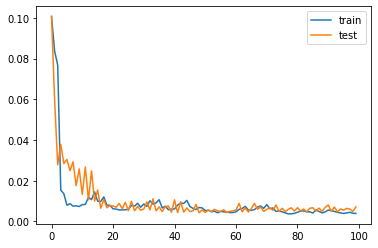

In [4]:
# design network
model = Sequential()
model.add(LSTM(67, input_shape=(X_train.shape[1], X_train.shape[2]), dropout = 0.3))
model.add(Dense(67))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
# fit network
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [5]:
yhat = model.predict(X_test)
X_test_new = X_test.reshape((X_test.shape[0], X_test.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, X_test_new[:, 1:]), axis=1)
inv_yhat = mm.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
y_test = y_test.reshape((len(y_test), 1))
inv_y = np.concatenate((y_test, X_test_new[:, 1:]), axis=1)
inv_y = mm.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = mse(inv_y, inv_yhat)**0.5
print('Test RMSE: %.3f' % rmse)

11/11 [==============================] - 0s 2ms/step
Test RMSE: 0.259


35/35 [==============================] - 0s 1ms/step


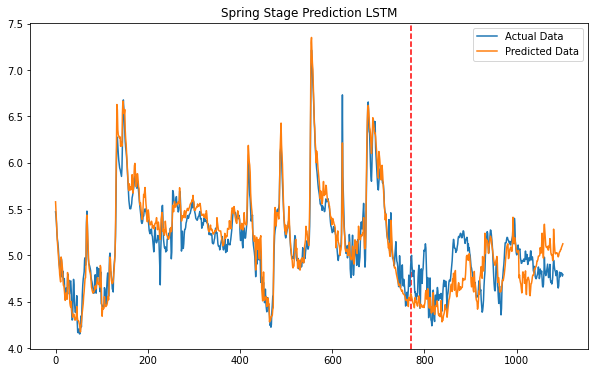

In [6]:

df_X_ss= X_ss.reshape(X_ss.shape[0], 1, X_ss.shape[1])
y_predict = model.predict(df_X_ss)#forward pass

rescale_y_predict = mm.inverse_transform(y_predict) #reverse transformation
dataY_plot = mm.inverse_transform(y_mm)
plt.figure(figsize=(10,6)) #plotting
plt.axvline(x=770, c='r', linestyle='--') #size of the training set

plt.plot(dataY_plot, label='Actual Data') #actual plot
plt.plot(rescale_y_predict, label='Predicted Data') #predicted plot
plt.title('Spring Stage Prediction LSTM')
plt.legend()
plt.show()

In [34]:
####### XAI
import shap
import tensorflow as tf

tf.compat.v1.disable_v2_behavior() 

In [35]:
X_train=X_ss[:100,:]
X_test=X_ss[770:800,:]


X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
#X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
print(X_train.shape,  X_test.shape)


(100, 1, 67) (30, 67)


In [37]:
explainer = shap.KernelExplainer(model=model, data=X_train)

Provided model function fails when applied to the provided data set.


RuntimeError: Exception encountered when calling layer "lstm" "                 f"(type LSTM).

resource: Attempting to capture an EagerTensor without building a function.

Call arguments received by layer "lstm" "                 f"(type LSTM):
  • inputs=tf.Tensor(shape=(100, 1, 67), dtype=float32)
  • mask=None
  • training=tf.Tensor(shape=(), dtype=bool)
  • initial_state=None

In [30]:
shap_values = explainer.shap_values(X_test)

NameError: name 'explainer' is not defined